In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

np.random.seed(42)
torch.manual_seed(42)

In [2]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()
        self.dp = torch.nn.Dropout(p=0.3)

    # 前向传播
    def forward(self, x):
        y = self.relu1(self.conv1(x))
        y = self.pool1(y)
        y = self.relu2(self.conv2(y))
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.relu3(self.fc1(y))
        y = self.dp(y)
        y = self.relu4(self.fc2(y))
        y = self.dp(y)
        y = self.relu5(self.fc3(y))
        return y

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]),
])
test_set = datasets.MNIST(root='/cephfs/dongyulong/work/wudao/data/', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
model_path = '/cephfs/dongyulong/work/wudao/model/0.0003_model.pk'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
  (dp): Dropout(p=0.3, inplace=False)
)

In [4]:
def fgsm_attack(input, epsilon, attack_target, model, loss_func):
    pert_out = input.clone().detach()
    pert_out.requires_grad = True
    optimizer = torch.optim.Adam([pert_out])
    output = model(pert_out)
    loss = loss_func(output, attack_target)
    optimizer.zero_grad()
    loss.backward()
    data_grad = pert_out.grad.data
    pert_out.data = pert_out.data - epsilon * data_grad.sign()
    pert_out = torch.clamp(pert_out, -1, 1)
    return pert_out


def ifgsm_attack(input, epsilon, iter, attack_target, model, loss_func):
    pert_out = input.clone().detach()
    pert_out.requires_grad = True
    optimizer = torch.optim.Adam([pert_out])
    for i in range(iter):
        output = model(pert_out)
        loss = loss_func(output, attack_target)
        optimizer.zero_grad()
        loss.backward()
        data_grad = pert_out.grad.data
        pert_out.data = pert_out.data - epsilon * data_grad.sign()
        pert_out.data = torch.clamp(pert_out, -1, 1)
        # print(pert_out)
        
    return pert_out


def mifgsm_attack(input, epsilon, iter, attack_target, model, loss_func):
    decay_factor = 1.0
    pert_out = input.clone().detach()
    pert_out.requires_grad = True
    optimizer = torch.optim.Adam([pert_out])
    g = 0
    for i in range(iter):
        output = model(pert_out)
        loss = loss_func(output, attack_target)
        optimizer.zero_grad()
        loss.backward()
        data_grad = pert_out.grad.data
        g = decay_factor * g + data_grad/torch.norm(data_grad,p=1)
        pert_out.data = pert_out.data - epsilon * torch.sign(g)
        pert_out.data = torch.clamp(pert_out, -1, 1)

    return pert_out

In [5]:
def test(model, device, test_loader, attack_target, epsilon, attack):
    correct = 0
    total = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1)[1] 
        if attack_target.item() == init_pred.item():
            continue
        total += 1
        
        loss_func = torch.nn.CrossEntropyLoss()

        if attack == "fgsm":
            perturbed_data = fgsm_attack(data, epsilon, attack_target, model, loss_func)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data, epsilon, 10, attack_target, model, loss_func)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data, epsilon, 10, attack_target, model, loss_func)

        output = model(perturbed_data)
        final_pred = output.max(1)[1]
        if final_pred.item() != target.item():
            correct += 1
        if (epsilon == 0) and (len(adv_examples) < 10):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(total)
    print("Attack: {}\tEpsilon: {}\tAttack Accuracy = {} / {} = {}".format(attack, round(epsilon, 3), correct, total, final_acc))

    return final_acc, adv_examples


Attack: fgsm	Epsilon: 0.1	Attack Accuracy = 829 / 9013 = 0.0919782536336403
Attack: fgsm	Epsilon: 0.12	Attack Accuracy = 1157 / 9013 = 0.12837013203151004
Attack: fgsm	Epsilon: 0.14	Attack Accuracy = 1523 / 9013 = 0.16897814268279152
Attack: fgsm	Epsilon: 0.16	Attack Accuracy = 1930 / 9013 = 0.21413513813380672
Attack: fgsm	Epsilon: 0.18	Attack Accuracy = 2411 / 9013 = 0.2675024963940974
Attack: fgsm	Epsilon: 0.2	Attack Accuracy = 3005 / 9013 = 0.33340730056584933
Attack: fgsm	Epsilon: 0.22	Attack Accuracy = 3653 / 9013 = 0.4053034505713969
Attack: fgsm	Epsilon: 0.24	Attack Accuracy = 4346 / 9013 = 0.4821923887717741
Attack: fgsm	Epsilon: 0.26	Attack Accuracy = 5072 / 9013 = 0.5627427049816931
Attack: fgsm	Epsilon: 0.28	Attack Accuracy = 5791 / 9013 = 0.6425163652501942
Attack: fgsm	Epsilon: 0.3	Attack Accuracy = 6356 / 9013 = 0.7052035948075003
Attack: fgsm	Epsilon: 0.32	Attack Accuracy = 6845 / 9013 = 0.7594585598579829
Attack: fgsm	Epsilon: 0.34	Attack Accuracy = 7241 / 9013 = 0.803

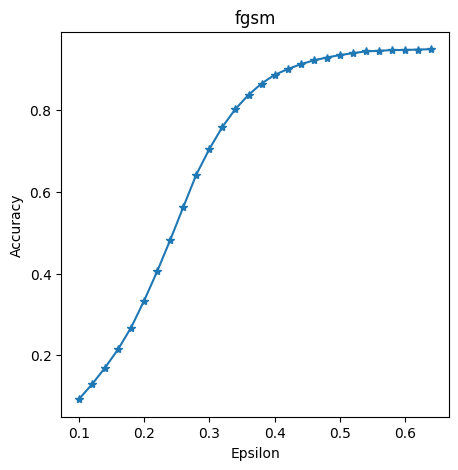

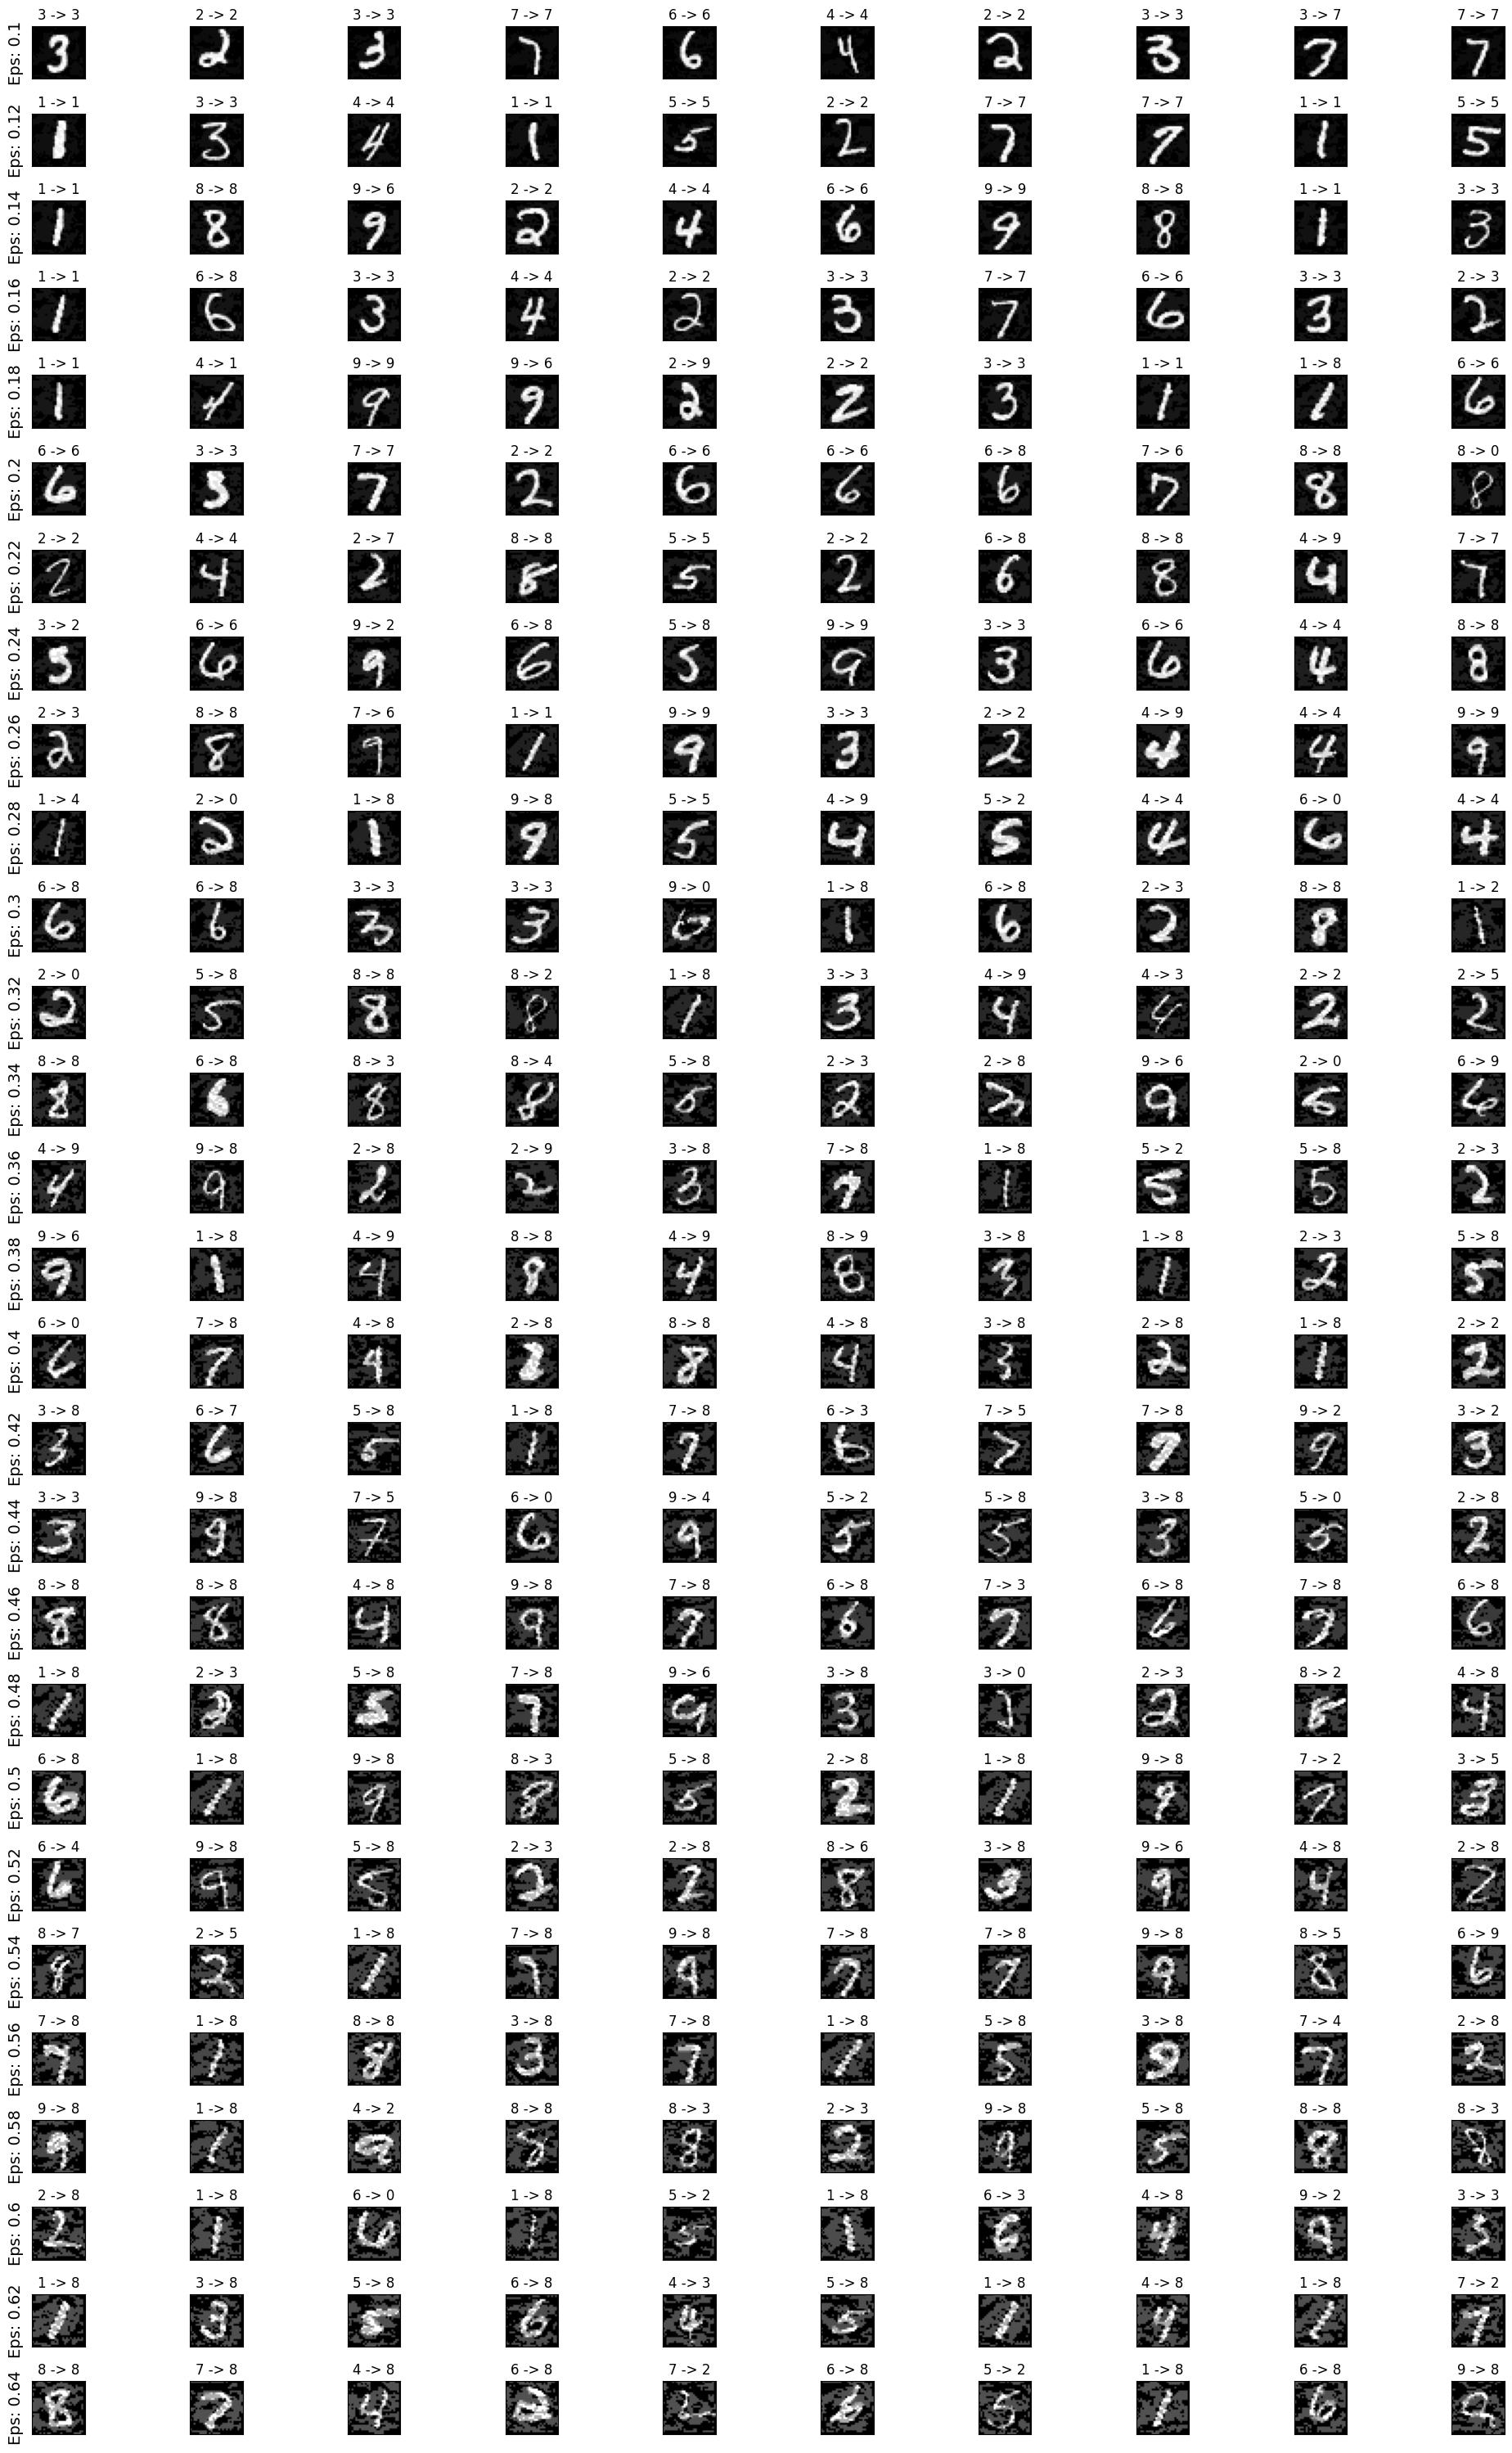

In [6]:
epsilons = np.arange(0.1, 0.65, 0.02)

accuracies = []
examples = []
attack_target = torch.tensor([0]).to('cuda')
for eps in epsilons:
    acc, ex = test(model, device, test_loader, attack_target, eps, 'fgsm')
    accuracies.append(acc)
    examples.append(ex)
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.title('fgsm')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

cnt = 0
plt.figure(figsize=(20, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(round(epsilons[i], 3)), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")

plt.tight_layout()
plt.show()

Attack: ifgsm	Epsilon: 0.001	Attack Accuracy = 221 / 9013 = 0.02452013757905248
Attack: ifgsm	Epsilon: 0.005	Attack Accuracy = 289 / 9013 = 0.03206479529568401
Attack: ifgsm	Epsilon: 0.009	Attack Accuracy = 525 / 9013 = 0.058249195606346386
Attack: ifgsm	Epsilon: 0.013	Attack Accuracy = 981 / 9013 = 0.10884278264728725
Attack: ifgsm	Epsilon: 0.017	Attack Accuracy = 1686 / 9013 = 0.1870631310329524
Attack: ifgsm	Epsilon: 0.021	Attack Accuracy = 2835 / 9013 = 0.3145456562742705
Attack: ifgsm	Epsilon: 0.025	Attack Accuracy = 4302 / 9013 = 0.47731055142571843
Attack: ifgsm	Epsilon: 0.029	Attack Accuracy = 5557 / 9013 = 0.6165538666370798
Attack: ifgsm	Epsilon: 0.033	Attack Accuracy = 6420 / 9013 = 0.7123044491290358
Attack: ifgsm	Epsilon: 0.037	Attack Accuracy = 7009 / 9013 = 0.7776544990569177
Attack: ifgsm	Epsilon: 0.041	Attack Accuracy = 7395 / 9013 = 0.8204815266836791
Attack: ifgsm	Epsilon: 0.045	Attack Accuracy = 7640 / 9013 = 0.8476644846333075
Attack: ifgsm	Epsilon: 0.049	Attack Ac

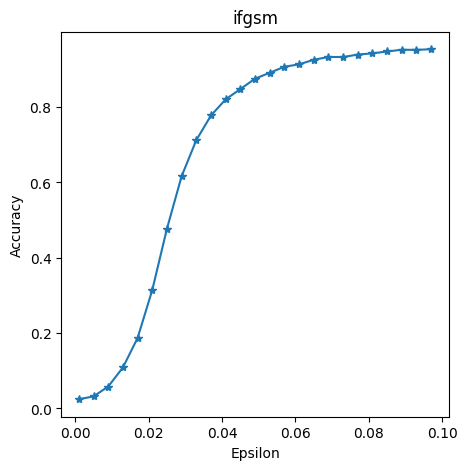

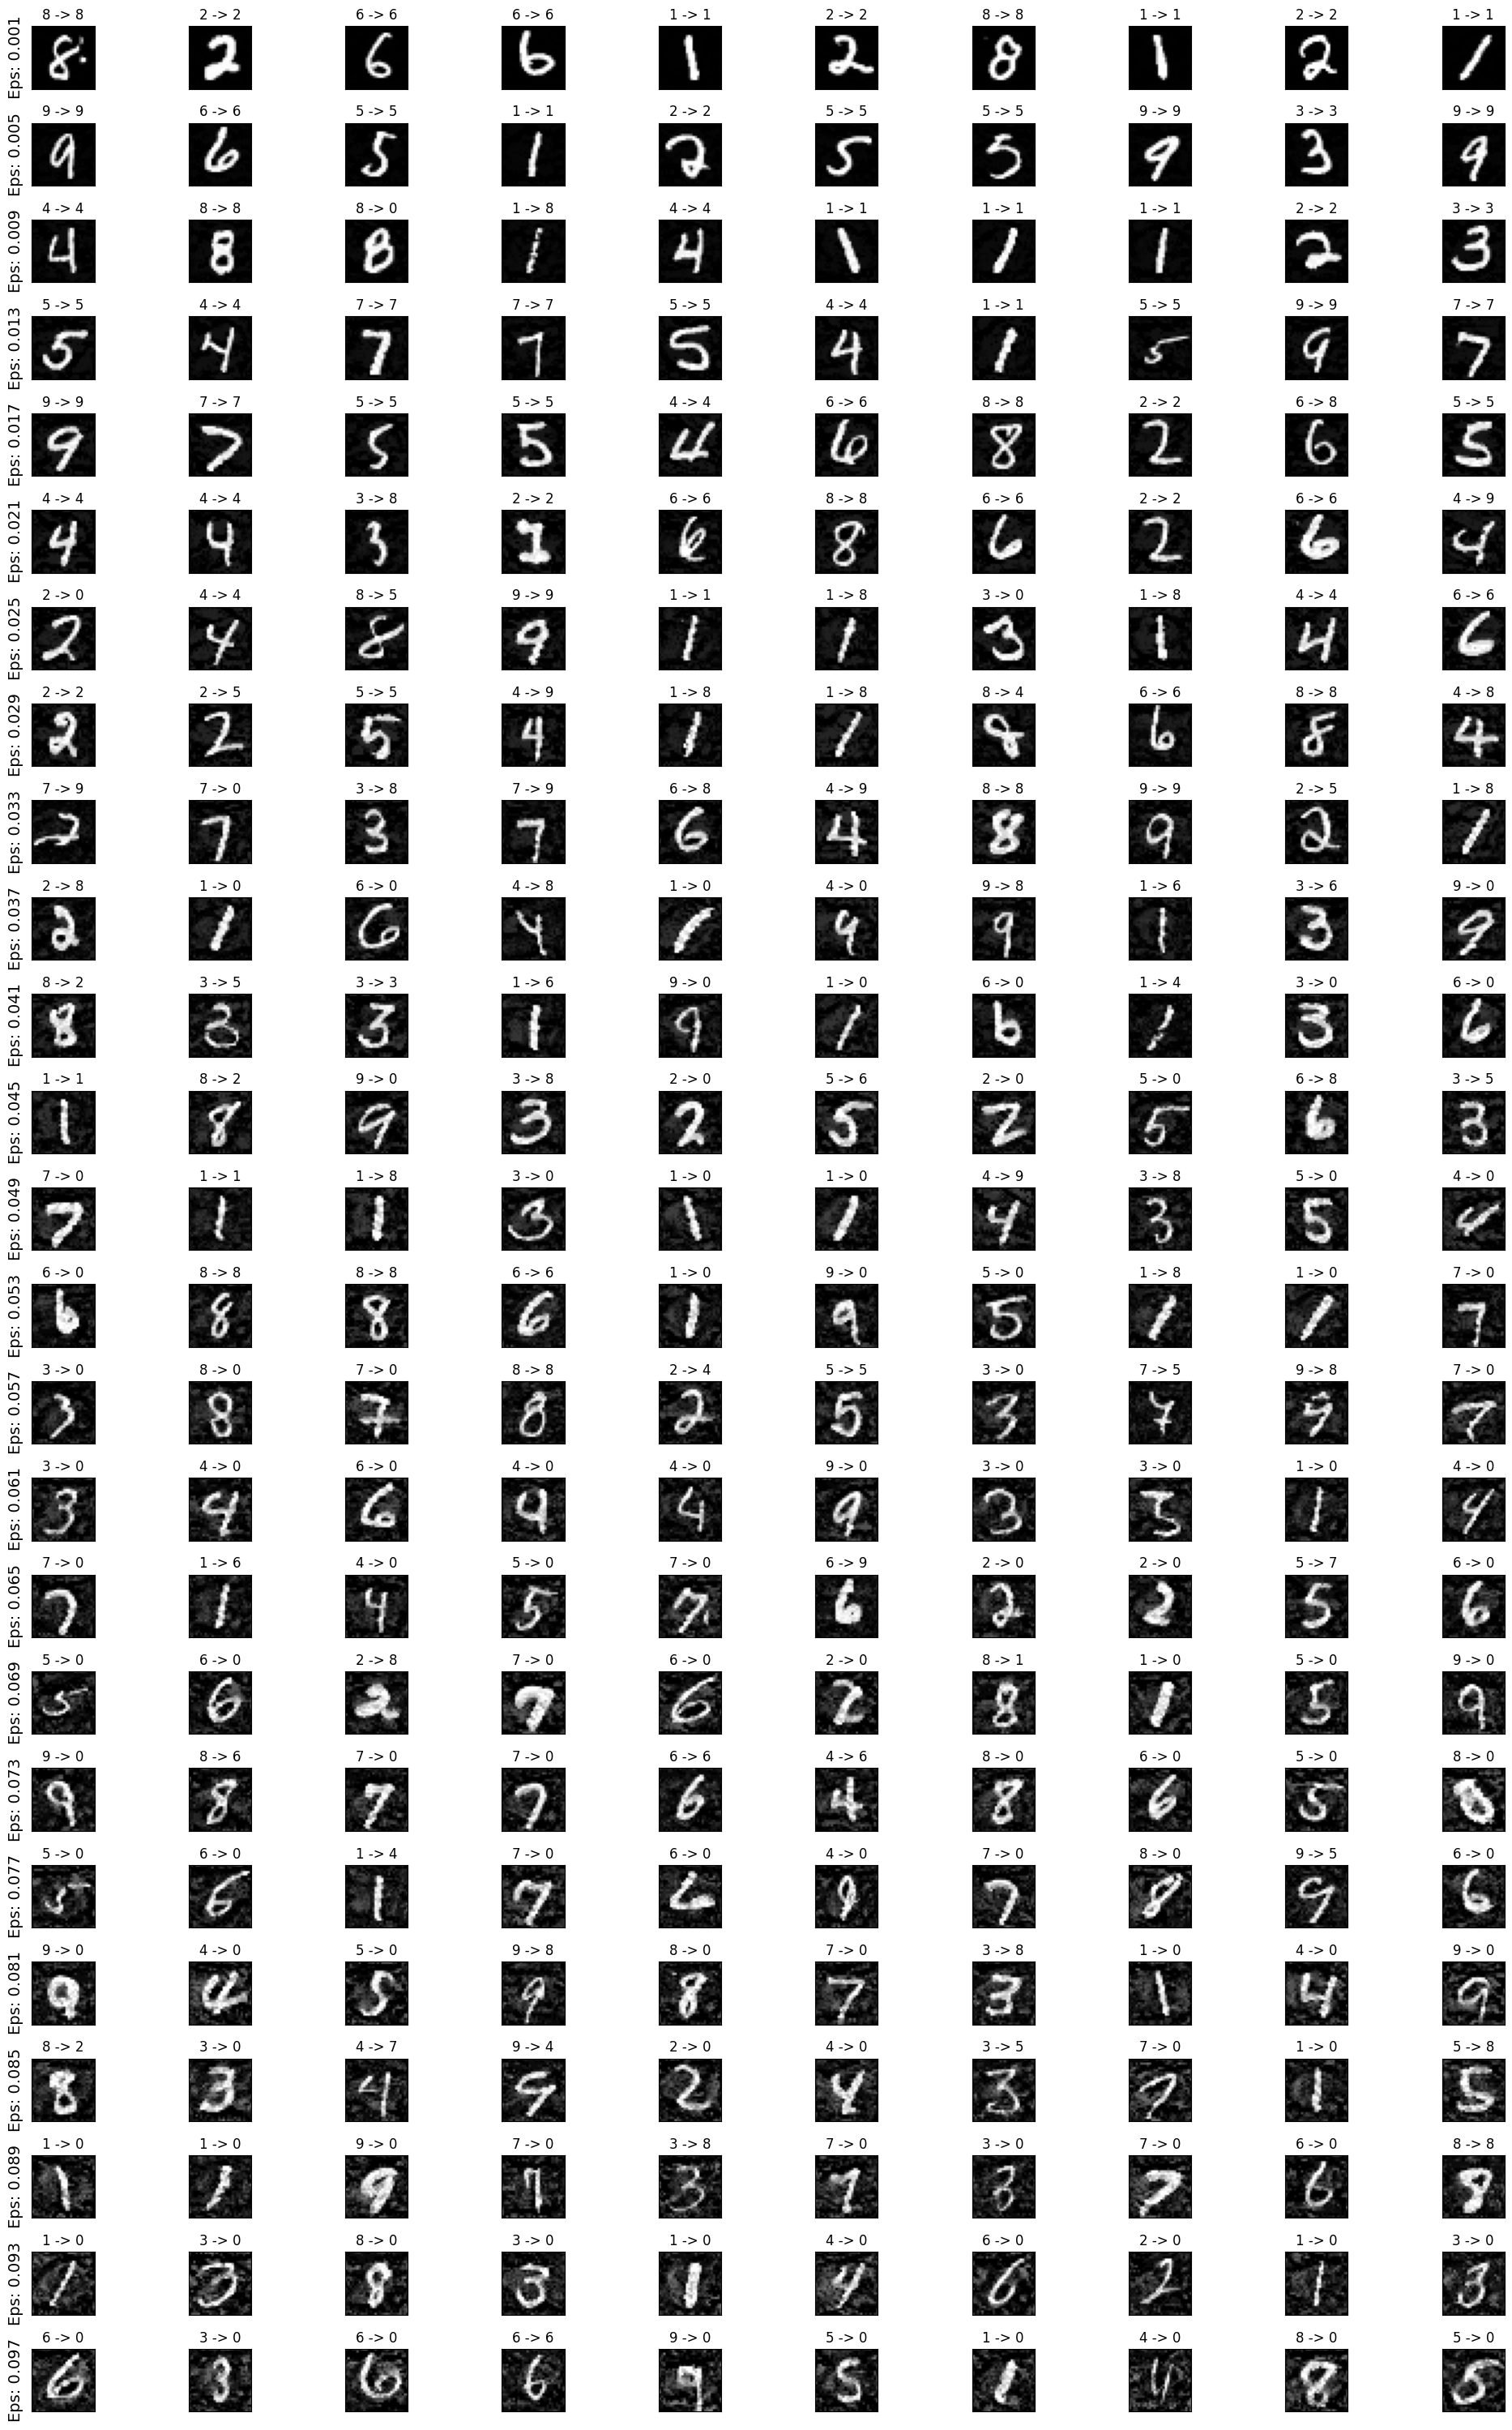

Attack: mifgsm	Epsilon: 0.001	Attack Accuracy = 222 / 9013 = 0.024631088427826475
Attack: mifgsm	Epsilon: 0.005	Attack Accuracy = 331 / 9013 = 0.03672473094419172
Attack: mifgsm	Epsilon: 0.009	Attack Accuracy = 683 / 9013 = 0.0757794297126373
Attack: mifgsm	Epsilon: 0.013	Attack Accuracy = 1397 / 9013 = 0.1549983357372684
Attack: mifgsm	Epsilon: 0.017	Attack Accuracy = 2455 / 9013 = 0.27238433374015314
Attack: mifgsm	Epsilon: 0.021	Attack Accuracy = 4009 / 9013 = 0.44480195273493844
Attack: mifgsm	Epsilon: 0.025	Attack Accuracy = 5765 / 9013 = 0.6396316431820703
Attack: mifgsm	Epsilon: 0.029	Attack Accuracy = 7140 / 9013 = 0.7921890602463109
Attack: mifgsm	Epsilon: 0.033	Attack Accuracy = 7882 / 9013 = 0.8745145900366138
Attack: mifgsm	Epsilon: 0.037	Attack Accuracy = 8260 / 9013 = 0.9164540108731832
Attack: mifgsm	Epsilon: 0.041	Attack Accuracy = 8453 / 9013 = 0.9378675246865639
Attack: mifgsm	Epsilon: 0.045	Attack Accuracy = 8530 / 9013 = 0.9464107400421613
Attack: mifgsm	Epsilon: 0.

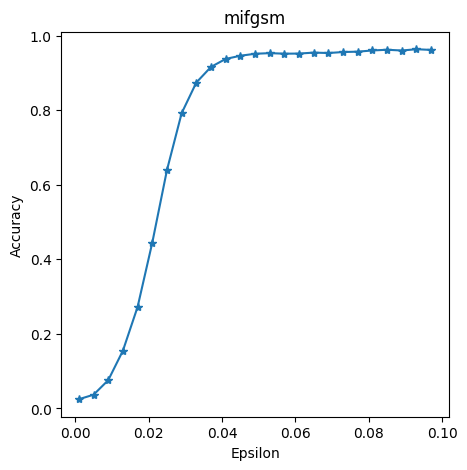

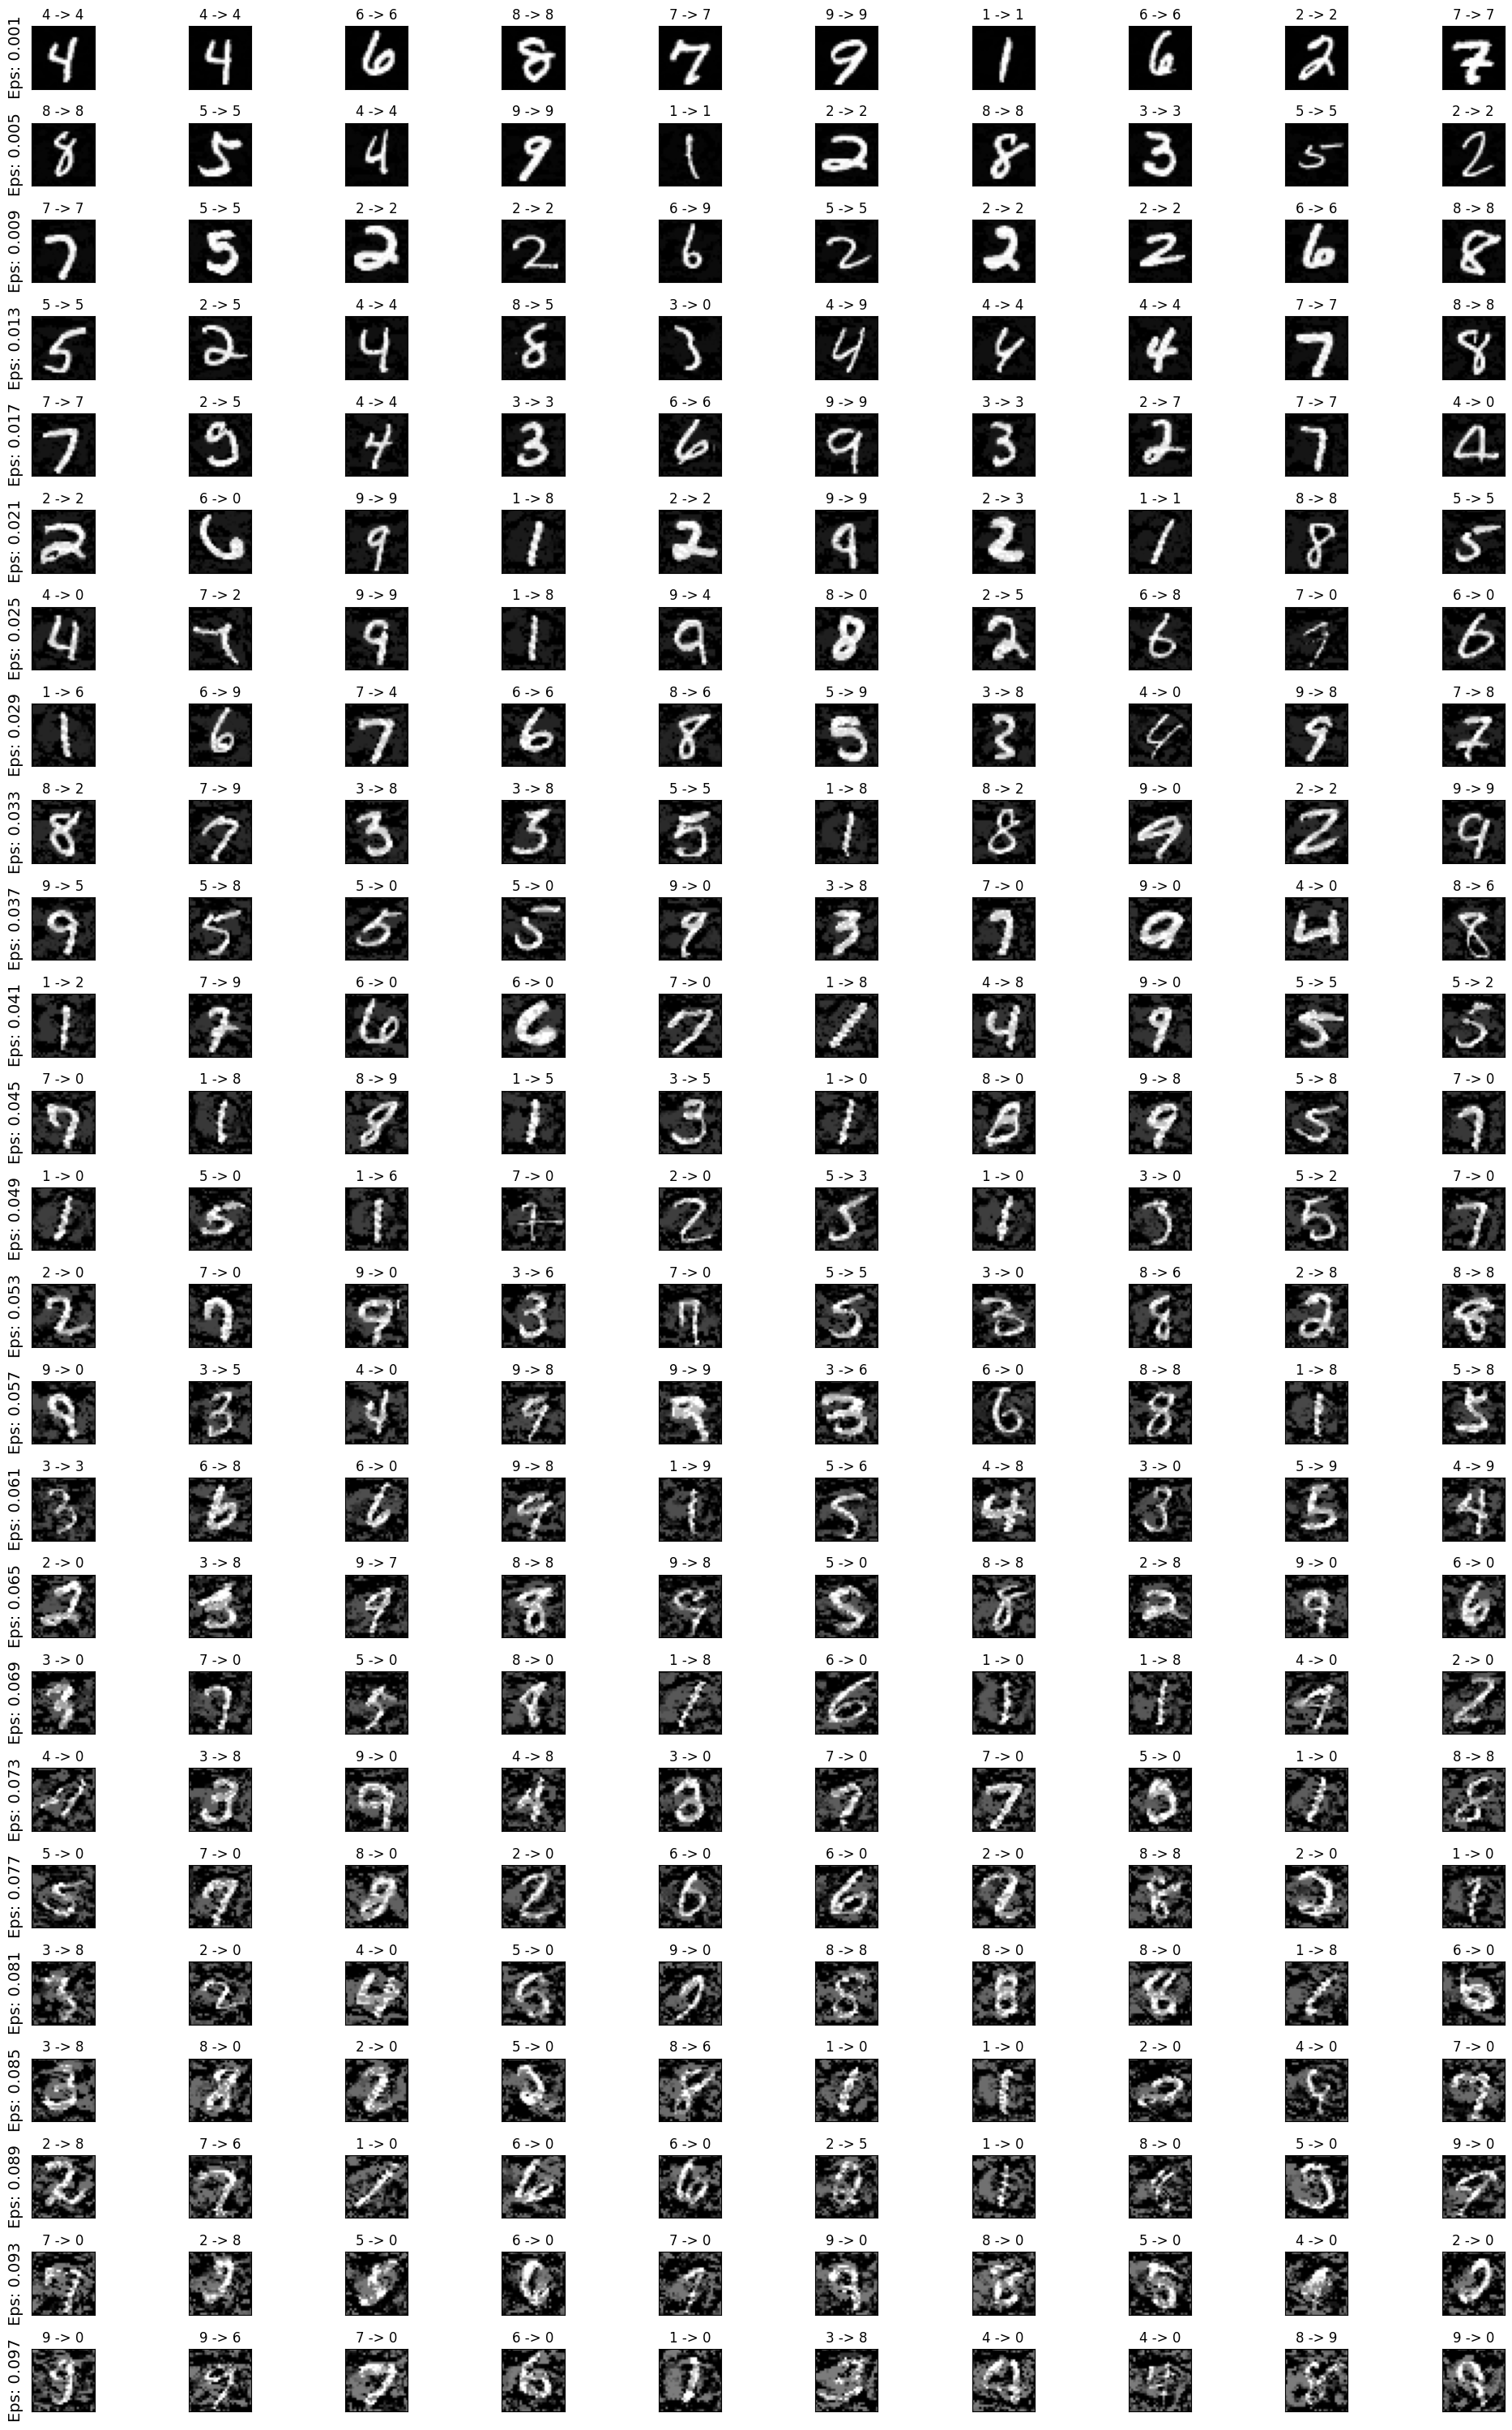

In [7]:
epsilons = np.arange(0.001, 0.1, 0.004)

for attack in ['ifgsm', 'mifgsm']:
    accuracies = []
    examples = []
    attack_target = torch.tensor([0]).to('cuda')
    for eps in epsilons:
        acc, ex = test(model, device, test_loader, attack_target, eps, attack)
        accuracies.append(acc)
        examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(20, 30))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(round(epsilons[i], 3)), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
            
    plt.tight_layout()
    plt.show()

In [11]:
for j in range(len(examples[i])):
    orig,adv,ex = examples[9][j]
    ex = torch.tensor(ex)
    transforms.ToPILImage()(ex).save(f'images/mifgsm_{j}.jpg')